In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Datos de entrenamiento

1. `(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()`: Carga el conjunto de datos MNIST, dividiéndolo en imágenes y etiquetas de entrenamiento. El segundo conjunto (de prueba) no se utiliza, por eso se ignora con `_`.

2. `train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')`: Redimensiona las imágenes de entrenamiento para que tengan un formato de 28x28 píxeles con 1 canal (escala de grises) y convierte los valores a tipo `float32`.

3. `train_images = (train_images - 127.5) / 127.5`: Normaliza los valores de los píxeles, que originalmente están entre 0 y 255, para que queden en el rango [-1, 1]. Esto es importante para mejorar el rendimiento de las redes neuronales, especialmente cuando se usan activaciones como `tanh`, que esperan entradas en este rango.

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128

Este código crea un conjunto de datos (`train_dataset`) a partir de las imágenes de entrenamiento (`train_images`). Utiliza la función `from_tensor_slices` para convertir el array de imágenes en un formato compatible con TensorFlow, y luego aplica dos operaciones:

1. `shuffle(BUFFER_SIZE)`: Desordena aleatoriamente las imágenes utilizando un tamaño de buffer especificado por `BUFFER_SIZE`, lo que ayuda a mezclar los datos antes del entrenamiento.
2. `batch(BATCH_SIZE)`: Agrupa las imágenes en lotes del tamaño `BATCH_SIZE`, lo que permite que el modelo entrene en pequeños subconjuntos de datos en cada iteración.

Esto organiza las imágenes de entrenamiento para ser usadas de manera eficiente en el proceso de entrenamiento del modelo.

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2024-10-04 11:33:01.198575: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-04 11:33:01.198600: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-04 11:33:01.198608: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-04 11:33:01.198625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-04 11:33:01.198637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


El generador toma un vector de 100 números aleatorios como entrada y lo transforma en una imagen de 28x28 píxeles. Usa capas densas, BatchNormalizatio), activación LeakyReLU, y varias capas Conv2DTranspose para aumentar el tamaño de la imagen gradualmente hasta obtener la salida final, que tiene una única capa de profundidad y usa la activación tanh para generar la imagen final.

In [6]:
def make_generator_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,)))  # Reduced units from 256 to 128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))  # Adjusted the reshape layer to match reduced filters

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))  # Reduced filters
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))  # Reduced filters
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

/Users/gustavogonzalez/miniconda3/envs/lab3_ia/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


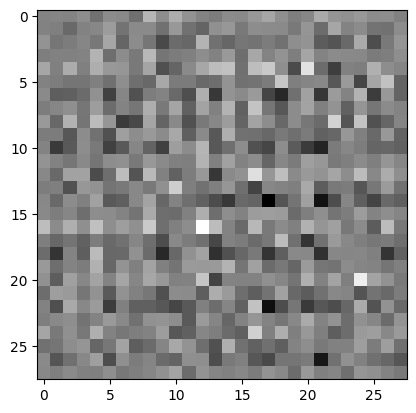

In [7]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

El discriminador toma una imagen de 28x28 píxeles como entrada y la procesa a través de capas convolucionales. Utiliza capas de `Dropout` para prevenir el sobreajuste y reduce la dimensionalidad de la imagen con una capa `Flatten`. Finalmente, una capa densa con una única salida determina si la imagen es real o generada por el modelo, proporcionando una probabilidad.

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))  # Reduced filters
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))  # Reduced filters
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00435991]], shape=(1, 1), dtype=float32)


/Users/gustavogonzalez/miniconda3/envs/lab3_ia/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1. `real_loss`: Calcula la pérdida del discriminador al clasificar imágenes reales. Compara las salidas del discriminador (`real_output`) con un conjunto de etiquetas de unos (porque las imágenes reales deberían clasificarse como "reales"). Se utiliza la función de pérdida de entropía cruzada (`cross_entropy`) para esta comparación.

2. `fake_loss`: Calcula la pérdida del discriminador al clasificar imágenes generadas (falsas). Compara las salidas del discriminador (`fake_output`) con etiquetas de ceros (porque las imágenes generadas deberían clasificarse como "falsas").

3. `total_loss`: Suma las pérdidas de las imágenes reales y generadas para obtener la pérdida total del discriminador.

El objetivo es minimizar esta pérdida, de modo que el discriminador mejore en clasificar imágenes reales como reales y falsas como falsas.

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Esta función define la pérdida del generador. El objetivo del generador es crear imágenes falsas que engañen al discriminador haciéndole creer que son reales.

1. `fake_output`: Es la salida del discriminador al clasificar las imágenes generadas por el generador.

2. `cross_entropy(tf.ones_like(fake_output), fake_output)`: Calcula la pérdida del generador comparando las salidas del discriminador (`fake_output`) con un conjunto de etiquetas de unos (porque el generador quiere que el discriminador clasifique las imágenes falsas como "reales"). Se utiliza la función de entropía cruzada para medir qué tan bien está logrando esto.

El generador trata de minimizar esta pérdida, de modo que el discriminador no pueda diferenciar entre las imágenes reales y las generadas.

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
EPOCHS = 160
noise_dim = 100
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

La anotación `@tf.function` optimiza la función compilándola para que sea más rápida.

1. **Generación de ruido**: Se crea un vector de ruido aleatorio con dimensiones `[BATCH_SIZE, noise_dim]` para alimentar al generador.

2. **GradientTape**: `
   - Se utilizan dos tf.GradientTape`, uno para el generador (`gen_tape`) y otro para el discriminador (`disc_tape`). Esto permite calcular los gradientes para ambos modelos.
   
3. **Generación de imágenes**: El generador usa el ruido para generar imágenes falsas (`generated_images`).

4. **Evaluación del discriminador**:
   - `real_output`: El discriminador procesa las imágenes reales y devuelve una clasificación.
   - `fake_output`: El discriminador evalúa las imágenes generadas y también devuelve una clasificación.

5. **Cálculo de pérdidas**:
   - `gen_loss`: Pérdida del generador, basada en qué tan bien las imágenes generadas engañan al discriminador.
   - `disc_loss`: Pérdida del discriminador, basada en su capacidad para diferenciar entre imágenes reales y generadas.

6. **Cálculo de gradientes**:
   - Se calculan los gradientes de la pérdida con respecto a los pesos entrenables del generador y el discriminador.

7. **Actualización de los modelos**:
   - `generator_optimizer.apply_gradients`: Aplica los gradientes calculados para actualizar los pesos del generador.
   - `discriminator_optimizer.apply_gradients`: Hace lo mismo para el discriminador.

En resumen, este bloque realiza un paso completo de entrenamiento, ajustando tanto el generador como el discriminador para que ambos mejoren en sus respectivos objetivos (engañar o no ser engañado).

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return the generator and discriminator loss for tracking
    return gen_loss, disc_loss


In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


1. **Inicio del bucle de épocas**:
   - El entrenamiento se repite por la cantidad de épocas definida en el argumento `epochs`.
   - Al inicio de cada época, se registra el tiempo con `start = time.time()` para medir cuánto tarda cada una.

2. **Entrenamiento por lotes**:
   - Dentro de cada época, se itera sobre cada lote de imágenes del conjunto de datos (`dataset`), llamando a la función `train_step(image_batch)` para entrenar el generador y discriminador en ese lote.

3. **Generación de imágenes**:
   - Se genera y guarda una imagen utilizando la función `generate_and_save_images(generator, epoch + 1, seed)`, donde el generador crea nuevas imágenes a partir de una semilla (`seed`), permitiendo un seguimiento visual del progreso de la GAN.

4. **Medición del tiempo**:
   - Se calcula y muestra el tiempo que tomó completar cada época con `print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))`.

5. **Generación final**:
   - Después de la última época, se genera una imagen final con el mismo método de visualización.

En resumen, esta función coordina el entrenamiento de la GAN durante múltiples épocas, mide el tiempo por cada una y genera imágenes en cada iteración para ver cómo mejora la calidad de las imágenes generadas.

In [16]:
# Initialize lists to track losses
generator_losses = []
discriminator_losses = []
avg_gen_losses = []
avg_disc_losses = []

def train(dataset, epochs):
  for epoch in range(epochs):
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0
    start = time.time()

    for image_batch in dataset:
      d_loss, g_loss = train_step(image_batch)

      # Append losses to the lists
      discriminator_losses.append(d_loss)
      generator_losses.append(g_loss)

      # Accumulate losses for the epoch
      total_gen_loss += g_loss
      total_disc_loss += d_loss
      num_batches += 1

    # Compute average losses for the epoch
    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches

    avg_gen_losses.append(avg_gen_loss)
    avg_disc_losses.append(avg_disc_loss)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    if epoch % 10 == 0:
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f'Epoch {epoch}, Average Discriminator Loss: {avg_disc_loss}, Average Generator Loss: {avg_gen_loss}')

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


2024-10-04 11:33:02.293986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-10-04 11:33:17.363303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


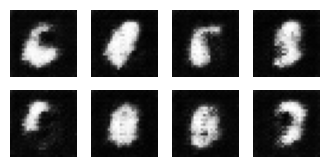

Time for epoch 1 is 15.765561819076538 sec
Epoch 0, Average Discriminator Loss: 0.8907341957092285, Average Generator Loss: 0.8942687511444092


2024-10-04 11:33:29.440596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 2 is 11.935695886611938 sec
Epoch 1, Average Discriminator Loss: 0.9315526485443115, Average Generator Loss: 1.0825157165527344


2024-10-04 11:33:41.337762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 3 is 11.89575719833374 sec
Epoch 2, Average Discriminator Loss: 0.7749339938163757, Average Generator Loss: 1.3378267288208008


2024-10-04 11:33:53.228442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 4 is 11.88838505744934 sec
Epoch 3, Average Discriminator Loss: 0.7289117574691772, Average Generator Loss: 1.3919665813446045


2024-10-04 11:34:05.114528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 5 is 11.883661985397339 sec
Epoch 4, Average Discriminator Loss: 0.7117860317230225, Average Generator Loss: 1.4077868461608887


2024-10-04 11:34:17.016445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 6 is 11.89968204498291 sec
Epoch 5, Average Discriminator Loss: 0.7123739719390869, Average Generator Loss: 1.3987159729003906


2024-10-04 11:34:28.838829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 7 is 11.820014953613281 sec
Epoch 6, Average Discriminator Loss: 0.7068474292755127, Average Generator Loss: 1.3992236852645874


2024-10-04 11:34:40.710639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 8 is 11.868820905685425 sec
Epoch 7, Average Discriminator Loss: 0.7067475318908691, Average Generator Loss: 1.3996281623840332


2024-10-04 11:34:52.526772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 9 is 11.813254117965698 sec
Epoch 8, Average Discriminator Loss: 0.7024708986282349, Average Generator Loss: 1.3978936672210693


2024-10-04 11:35:04.424785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 10 is 11.895306825637817 sec
Epoch 9, Average Discriminator Loss: 0.7006304264068604, Average Generator Loss: 1.3988401889801025


2024-10-04 11:35:16.331567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


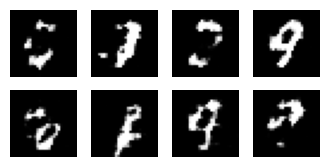

Time for epoch 11 is 11.968114137649536 sec
Epoch 10, Average Discriminator Loss: 0.7047752141952515, Average Generator Loss: 1.3901852369308472


2024-10-04 11:35:28.289380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 12 is 11.89235782623291 sec
Epoch 11, Average Discriminator Loss: 0.7010162472724915, Average Generator Loss: 1.3971474170684814


2024-10-04 11:35:40.158003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 13 is 11.866070747375488 sec
Epoch 12, Average Discriminator Loss: 0.7051095962524414, Average Generator Loss: 1.384450078010559


2024-10-04 11:35:51.919237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 14 is 11.759122848510742 sec
Epoch 13, Average Discriminator Loss: 0.6948481202125549, Average Generator Loss: 1.3987929821014404


2024-10-04 11:36:03.740867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 15 is 11.819600820541382 sec
Epoch 14, Average Discriminator Loss: 0.6920527219772339, Average Generator Loss: 1.4011338949203491


2024-10-04 11:36:15.673673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 16 is 11.930902004241943 sec
Epoch 15, Average Discriminator Loss: 0.6903218030929565, Average Generator Loss: 1.4017670154571533


2024-10-04 11:36:27.734736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 17 is 12.059087991714478 sec
Epoch 16, Average Discriminator Loss: 0.6906940937042236, Average Generator Loss: 1.3984589576721191


2024-10-04 11:36:39.815981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 18 is 12.079447984695435 sec
Epoch 17, Average Discriminator Loss: 0.6964705586433411, Average Generator Loss: 1.3903295993804932


2024-10-04 11:36:53.269688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 19 is 13.452174186706543 sec
Epoch 18, Average Discriminator Loss: 0.708077073097229, Average Generator Loss: 1.3869341611862183


2024-10-04 11:37:06.006170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 20 is 12.734500885009766 sec
Epoch 19, Average Discriminator Loss: 0.6972318291664124, Average Generator Loss: 1.3870980739593506


2024-10-04 11:37:18.549486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


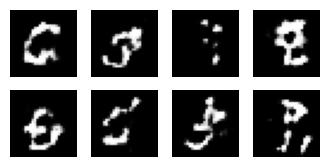

Time for epoch 21 is 12.615522146224976 sec
Epoch 20, Average Discriminator Loss: 0.6951169371604919, Average Generator Loss: 1.3926656246185303


2024-10-04 11:37:31.161158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 22 is 12.536246061325073 sec
Epoch 21, Average Discriminator Loss: 0.6968310475349426, Average Generator Loss: 1.3891345262527466


2024-10-04 11:37:43.711556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 23 is 12.54884672164917 sec
Epoch 22, Average Discriminator Loss: 0.6974131464958191, Average Generator Loss: 1.3884254693984985


2024-10-04 11:37:56.286328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 24 is 12.572947978973389 sec
Epoch 23, Average Discriminator Loss: 0.6974234580993652, Average Generator Loss: 1.3938679695129395


2024-10-04 11:38:09.272926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 25 is 12.985220193862915 sec
Epoch 24, Average Discriminator Loss: 0.7062519788742065, Average Generator Loss: 1.3840100765228271


2024-10-04 11:38:21.990839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 26 is 12.716012954711914 sec
Epoch 25, Average Discriminator Loss: 0.7128986120223999, Average Generator Loss: 1.3740460872650146


2024-10-04 11:38:34.628858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 27 is 12.636264324188232 sec
Epoch 26, Average Discriminator Loss: 0.6949936747550964, Average Generator Loss: 1.3930823802947998


2024-10-04 11:38:48.655419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 28 is 14.024680137634277 sec
Epoch 27, Average Discriminator Loss: 0.6949599981307983, Average Generator Loss: 1.3935787677764893


2024-10-04 11:39:05.501316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 29 is 16.845000982284546 sec
Epoch 28, Average Discriminator Loss: 0.6916773319244385, Average Generator Loss: 1.3956471681594849


2024-10-04 11:39:19.030424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 30 is 13.526441097259521 sec
Epoch 29, Average Discriminator Loss: 0.6909856796264648, Average Generator Loss: 1.394374132156372


2024-10-04 11:39:32.067663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


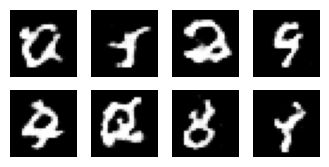

Time for epoch 31 is 13.115900754928589 sec
Epoch 30, Average Discriminator Loss: 0.6918792128562927, Average Generator Loss: 1.392256736755371


2024-10-04 11:39:45.202064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 32 is 13.052255868911743 sec
Epoch 31, Average Discriminator Loss: 0.6930627822875977, Average Generator Loss: 1.3909460306167603


2024-10-04 11:39:58.186080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 33 is 12.982394218444824 sec
Epoch 32, Average Discriminator Loss: 0.6975152492523193, Average Generator Loss: 1.3891758918762207


2024-10-04 11:40:11.265671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 34 is 13.077547073364258 sec
Epoch 33, Average Discriminator Loss: 0.7005122303962708, Average Generator Loss: 1.384914517402649


2024-10-04 11:40:24.331321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 35 is 13.063928127288818 sec
Epoch 34, Average Discriminator Loss: 0.6977748870849609, Average Generator Loss: 1.3893247842788696


2024-10-04 11:40:37.114600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 36 is 12.781578063964844 sec
Epoch 35, Average Discriminator Loss: 0.6982787847518921, Average Generator Loss: 1.3868436813354492


2024-10-04 11:40:49.717479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 37 is 12.600781202316284 sec
Epoch 36, Average Discriminator Loss: 0.6938672065734863, Average Generator Loss: 1.3888568878173828


2024-10-04 11:41:02.441450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 38 is 12.721729040145874 sec
Epoch 37, Average Discriminator Loss: 0.703224778175354, Average Generator Loss: 1.3823089599609375


2024-10-04 11:41:15.234032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 39 is 12.79026198387146 sec
Epoch 38, Average Discriminator Loss: 0.6959922313690186, Average Generator Loss: 1.3895103931427002


2024-10-04 11:41:28.217388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 40 is 12.981604099273682 sec
Epoch 39, Average Discriminator Loss: 0.6964712142944336, Average Generator Loss: 1.3866219520568848


2024-10-04 11:41:41.236286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


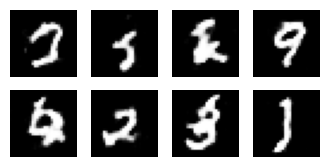

Time for epoch 41 is 13.091063022613525 sec
Epoch 40, Average Discriminator Loss: 0.6922182440757751, Average Generator Loss: 1.3925312757492065


2024-10-04 11:41:54.147826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 42 is 12.835553169250488 sec
Epoch 41, Average Discriminator Loss: 0.6945650577545166, Average Generator Loss: 1.387527346611023


2024-10-04 11:42:07.023735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 43 is 12.874151945114136 sec
Epoch 42, Average Discriminator Loss: 0.6922262907028198, Average Generator Loss: 1.3913061618804932


2024-10-04 11:42:19.921200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 44 is 12.895072937011719 sec
Epoch 43, Average Discriminator Loss: 0.6954922676086426, Average Generator Loss: 1.3836125135421753


2024-10-04 11:42:32.710078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 45 is 12.787277221679688 sec
Epoch 44, Average Discriminator Loss: 0.7001233696937561, Average Generator Loss: 1.3894528150558472


2024-10-04 11:42:45.380939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 46 is 12.669034957885742 sec
Epoch 45, Average Discriminator Loss: 0.6949062943458557, Average Generator Loss: 1.3874320983886719


2024-10-04 11:42:58.075115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 47 is 12.692305088043213 sec
Epoch 46, Average Discriminator Loss: 0.6912432312965393, Average Generator Loss: 1.3912986516952515


2024-10-04 11:43:10.918158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 48 is 12.841199159622192 sec
Epoch 47, Average Discriminator Loss: 0.6922271251678467, Average Generator Loss: 1.390446424484253


2024-10-04 11:43:23.474135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 49 is 12.554582118988037 sec
Epoch 48, Average Discriminator Loss: 0.6920570731163025, Average Generator Loss: 1.388708233833313


2024-10-04 11:43:35.970752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 50 is 12.49409794807434 sec
Epoch 49, Average Discriminator Loss: 0.6949471235275269, Average Generator Loss: 1.3886514902114868


2024-10-04 11:43:48.183059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


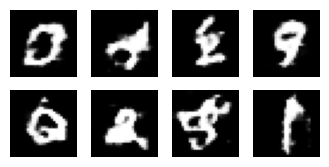

Time for epoch 51 is 12.28313398361206 sec
Epoch 50, Average Discriminator Loss: 0.6973417401313782, Average Generator Loss: 1.3843913078308105


2024-10-04 11:44:29.085693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 52 is 40.829097270965576 sec
Epoch 51, Average Discriminator Loss: 0.7031724452972412, Average Generator Loss: 1.3915081024169922


2024-10-04 11:44:42.395210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 53 is 13.307490110397339 sec
Epoch 52, Average Discriminator Loss: 0.7077050805091858, Average Generator Loss: 1.3698121309280396


2024-10-04 11:44:53.458991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 54 is 11.06175684928894 sec
Epoch 53, Average Discriminator Loss: 0.7073351144790649, Average Generator Loss: 1.381637692451477


2024-10-04 11:45:04.491590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 55 is 11.030647039413452 sec
Epoch 54, Average Discriminator Loss: 0.693725049495697, Average Generator Loss: 1.3865454196929932


2024-10-04 11:45:38.521854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 56 is 34.02843999862671 sec
Epoch 55, Average Discriminator Loss: 0.6937365531921387, Average Generator Loss: 1.3874338865280151


2024-10-04 11:45:51.848846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 57 is 13.324857711791992 sec
Epoch 56, Average Discriminator Loss: 0.6943057179450989, Average Generator Loss: 1.388808250427246


2024-10-04 11:46:02.946390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 58 is 11.095741033554077 sec
Epoch 57, Average Discriminator Loss: 0.6941040754318237, Average Generator Loss: 1.3883416652679443


2024-10-04 11:46:14.032907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 59 is 11.084599018096924 sec
Epoch 58, Average Discriminator Loss: 0.6939075589179993, Average Generator Loss: 1.3893831968307495


2024-10-04 11:49:18.950296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 60 is 184.9154670238495 sec
Epoch 59, Average Discriminator Loss: 0.6926408410072327, Average Generator Loss: 1.3879379034042358


2024-10-04 11:49:30.023521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


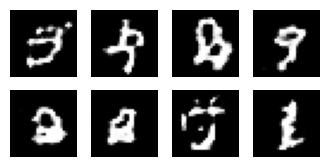

Time for epoch 61 is 11.13292384147644 sec
Epoch 60, Average Discriminator Loss: 0.6977791786193848, Average Generator Loss: 1.3878419399261475


2024-10-04 11:49:41.156360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 62 is 11.069985151290894 sec
Epoch 61, Average Discriminator Loss: 0.7067800164222717, Average Generator Loss: 1.3731828927993774


2024-10-04 11:49:52.208392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 63 is 11.050112009048462 sec
Epoch 62, Average Discriminator Loss: 0.7047910094261169, Average Generator Loss: 1.3733919858932495


2024-10-04 11:50:08.451778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 64 is 16.241152048110962 sec
Epoch 63, Average Discriminator Loss: 0.6996737718582153, Average Generator Loss: 1.3862727880477905


2024-10-04 11:50:19.497587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 65 is 11.043879985809326 sec
Epoch 64, Average Discriminator Loss: 0.6991832256317139, Average Generator Loss: 1.384341835975647


2024-10-04 11:50:30.568953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 66 is 11.069416046142578 sec
Epoch 65, Average Discriminator Loss: 0.6967257261276245, Average Generator Loss: 1.3867850303649902


2024-10-04 11:50:48.337473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 67 is 17.767786026000977 sec
Epoch 66, Average Discriminator Loss: 0.6940586566925049, Average Generator Loss: 1.3914433717727661


2024-10-04 11:52:47.875016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 68 is 119.53353905677795 sec
Epoch 67, Average Discriminator Loss: 0.6935613751411438, Average Generator Loss: 1.391353964805603


2024-10-04 11:52:58.899412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 69 is 11.022279739379883 sec
Epoch 68, Average Discriminator Loss: 0.6926069259643555, Average Generator Loss: 1.390957236289978


2024-10-04 11:53:09.978046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 70 is 11.076420783996582 sec
Epoch 69, Average Discriminator Loss: 0.6923146843910217, Average Generator Loss: 1.391125202178955


2024-10-04 11:53:21.082390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


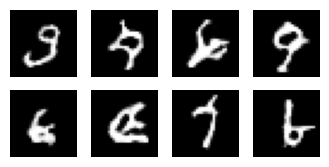

Time for epoch 71 is 11.164250135421753 sec
Epoch 70, Average Discriminator Loss: 0.6923033595085144, Average Generator Loss: 1.3908169269561768


2024-10-04 11:54:55.191893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 72 is 94.0465259552002 sec
Epoch 71, Average Discriminator Loss: 0.6919782757759094, Average Generator Loss: 1.3904733657836914


2024-10-04 11:55:08.089414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 73 is 12.895467042922974 sec
Epoch 72, Average Discriminator Loss: 0.6920852065086365, Average Generator Loss: 1.3889108896255493


2024-10-04 11:55:21.004297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 74 is 12.910728931427002 sec
Epoch 73, Average Discriminator Loss: 0.6935279965400696, Average Generator Loss: 1.3887702226638794


2024-10-04 11:55:33.744850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 75 is 12.737600088119507 sec
Epoch 74, Average Discriminator Loss: 0.6924256682395935, Average Generator Loss: 1.3876144886016846


2024-10-04 11:55:46.174756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 76 is 12.426561832427979 sec
Epoch 75, Average Discriminator Loss: 0.7078518271446228, Average Generator Loss: 1.3825645446777344


2024-10-04 11:55:58.891917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 77 is 12.714426040649414 sec
Epoch 76, Average Discriminator Loss: 0.7099270224571228, Average Generator Loss: 1.3680593967437744


2024-10-04 11:56:11.875323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 78 is 12.980243921279907 sec
Epoch 77, Average Discriminator Loss: 0.7078824639320374, Average Generator Loss: 1.383895993232727


2024-10-04 11:56:24.587619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 79 is 12.707350015640259 sec
Epoch 78, Average Discriminator Loss: 0.696467936038971, Average Generator Loss: 1.3830796480178833


2024-10-04 11:56:37.245540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 80 is 12.65532398223877 sec
Epoch 79, Average Discriminator Loss: 0.7014252543449402, Average Generator Loss: 1.3836042881011963


2024-10-04 11:56:49.912982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


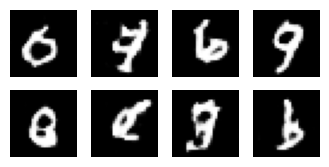

Time for epoch 81 is 12.735985040664673 sec
Epoch 80, Average Discriminator Loss: 0.6962460875511169, Average Generator Loss: 1.388190507888794


2024-10-04 11:57:02.185543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 82 is 12.198978900909424 sec
Epoch 81, Average Discriminator Loss: 0.6968171000480652, Average Generator Loss: 1.386117696762085


2024-10-04 11:57:14.204160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 83 is 12.015536785125732 sec
Epoch 82, Average Discriminator Loss: 0.6931292414665222, Average Generator Loss: 1.3875243663787842


2024-10-04 11:57:26.272986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 84 is 12.066512823104858 sec
Epoch 83, Average Discriminator Loss: 0.695281982421875, Average Generator Loss: 1.3902944326400757


2024-10-04 11:57:38.553551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 85 is 12.278378009796143 sec
Epoch 84, Average Discriminator Loss: 0.6926929950714111, Average Generator Loss: 1.3890366554260254


2024-10-04 11:57:50.794631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 86 is 12.238639116287231 sec
Epoch 85, Average Discriminator Loss: 0.6919557452201843, Average Generator Loss: 1.3890507221221924


2024-10-04 11:58:03.163584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 87 is 12.367215156555176 sec
Epoch 86, Average Discriminator Loss: 0.6948338747024536, Average Generator Loss: 1.3882293701171875


2024-10-04 11:58:15.624603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 88 is 12.45901608467102 sec
Epoch 87, Average Discriminator Loss: 0.6947706937789917, Average Generator Loss: 1.3875664472579956


2024-10-04 11:58:28.140185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 89 is 12.51383900642395 sec
Epoch 88, Average Discriminator Loss: 0.6937410831451416, Average Generator Loss: 1.38700532913208


2024-10-04 11:58:40.817250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 90 is 12.675302028656006 sec
Epoch 89, Average Discriminator Loss: 0.6969807147979736, Average Generator Loss: 1.3858383893966675


2024-10-04 11:58:53.533583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


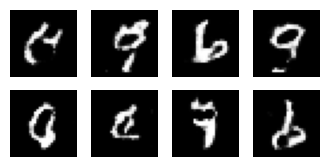

Time for epoch 91 is 12.882999181747437 sec
Epoch 90, Average Discriminator Loss: 0.6976231932640076, Average Generator Loss: 1.3863760232925415


2024-10-04 11:59:06.633665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 92 is 12.93036413192749 sec
Epoch 91, Average Discriminator Loss: 0.6976287364959717, Average Generator Loss: 1.38624906539917


2024-10-04 11:59:19.666367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 93 is 13.030694246292114 sec
Epoch 92, Average Discriminator Loss: 0.708575427532196, Average Generator Loss: 1.3757290840148926


2024-10-04 11:59:32.559913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 94 is 12.891745805740356 sec
Epoch 93, Average Discriminator Loss: 0.7010012269020081, Average Generator Loss: 1.3830260038375854


2024-10-04 11:59:45.471080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 95 is 12.90965223312378 sec
Epoch 94, Average Discriminator Loss: 0.6984772086143494, Average Generator Loss: 1.3808729648590088


2024-10-04 11:59:58.476446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 96 is 13.0037100315094 sec
Epoch 95, Average Discriminator Loss: 0.6960377097129822, Average Generator Loss: 1.3877052068710327


2024-10-04 12:00:11.384986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 97 is 12.906708002090454 sec
Epoch 96, Average Discriminator Loss: 0.6947349309921265, Average Generator Loss: 1.3884564638137817


2024-10-04 12:00:24.205520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 98 is 12.818572044372559 sec
Epoch 97, Average Discriminator Loss: 0.6937775015830994, Average Generator Loss: 1.3888683319091797


2024-10-04 12:00:37.158865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 99 is 12.95167088508606 sec
Epoch 98, Average Discriminator Loss: 0.6940110325813293, Average Generator Loss: 1.38871169090271


2024-10-04 12:00:50.145203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 100 is 12.98467206954956 sec
Epoch 99, Average Discriminator Loss: 0.6934622526168823, Average Generator Loss: 1.3882685899734497


2024-10-04 12:01:03.112525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


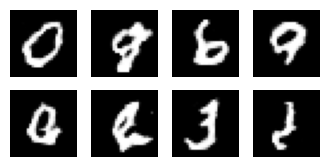

Time for epoch 101 is 13.040704011917114 sec
Epoch 100, Average Discriminator Loss: 0.6944594979286194, Average Generator Loss: 1.3893942832946777


2024-10-04 12:01:16.001597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 102 is 12.812578916549683 sec
Epoch 101, Average Discriminator Loss: 0.693886399269104, Average Generator Loss: 1.3884187936782837


2024-10-04 12:01:28.704055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 103 is 12.699576139450073 sec
Epoch 102, Average Discriminator Loss: 0.6926245093345642, Average Generator Loss: 1.3887282609939575


2024-10-04 12:01:41.338717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 104 is 12.63236117362976 sec
Epoch 103, Average Discriminator Loss: 0.6935887336730957, Average Generator Loss: 1.3875421285629272


2024-10-04 12:01:54.024432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 105 is 12.683583974838257 sec
Epoch 104, Average Discriminator Loss: 0.6966926455497742, Average Generator Loss: 1.3862143754959106


2024-10-04 12:02:06.668121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 106 is 12.641893863677979 sec
Epoch 105, Average Discriminator Loss: 0.7107317447662354, Average Generator Loss: 1.3789118528366089


2024-10-04 12:02:19.307620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 107 is 12.636718034744263 sec
Epoch 106, Average Discriminator Loss: 0.7036788463592529, Average Generator Loss: 1.3787548542022705


2024-10-04 12:02:32.136196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 108 is 12.826301336288452 sec
Epoch 107, Average Discriminator Loss: 0.7000297904014587, Average Generator Loss: 1.3819770812988281


2024-10-04 12:02:44.811723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 109 is 12.673133134841919 sec
Epoch 108, Average Discriminator Loss: 0.6961209774017334, Average Generator Loss: 1.3837913274765015


2024-10-04 12:02:57.618370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 110 is 12.804790019989014 sec
Epoch 109, Average Discriminator Loss: 0.6946922540664673, Average Generator Loss: 1.3858251571655273


2024-10-04 12:03:10.518816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


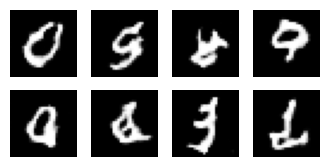

Time for epoch 111 is 12.972792863845825 sec
Epoch 110, Average Discriminator Loss: 0.6964098215103149, Average Generator Loss: 1.3871454000473022


2024-10-04 12:03:23.579352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 112 is 12.98480224609375 sec
Epoch 111, Average Discriminator Loss: 0.6948817372322083, Average Generator Loss: 1.3893357515335083


2024-10-04 12:03:36.410419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 113 is 12.828559160232544 sec
Epoch 112, Average Discriminator Loss: 0.6925219297409058, Average Generator Loss: 1.3899897336959839


2024-10-04 12:03:49.285853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 114 is 12.873336791992188 sec
Epoch 113, Average Discriminator Loss: 0.6930070519447327, Average Generator Loss: 1.3887666463851929


2024-10-04 12:04:02.172199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 115 is 12.884529113769531 sec
Epoch 114, Average Discriminator Loss: 0.694309413433075, Average Generator Loss: 1.3885082006454468


2024-10-04 12:04:14.943148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 116 is 12.769339799880981 sec
Epoch 115, Average Discriminator Loss: 0.6918784976005554, Average Generator Loss: 1.3880828619003296


2024-10-04 12:04:27.827473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 117 is 12.882660150527954 sec
Epoch 116, Average Discriminator Loss: 0.6931318640708923, Average Generator Loss: 1.388149380683899


2024-10-04 12:04:40.644461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 118 is 12.814728021621704 sec
Epoch 117, Average Discriminator Loss: 0.6953328251838684, Average Generator Loss: 1.3865951299667358


2024-10-04 12:04:53.464229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 119 is 12.817921161651611 sec
Epoch 118, Average Discriminator Loss: 0.699851930141449, Average Generator Loss: 1.3831626176834106


2024-10-04 12:05:06.214918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 120 is 12.748430728912354 sec
Epoch 119, Average Discriminator Loss: 0.7029274106025696, Average Generator Loss: 1.3781543970108032


2024-10-04 12:05:19.097417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


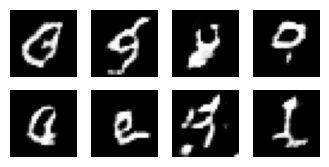

Time for epoch 121 is 12.9582040309906 sec
Epoch 120, Average Discriminator Loss: 0.6981608271598816, Average Generator Loss: 1.3855537176132202


2024-10-04 12:05:32.026693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 122 is 12.849991083145142 sec
Epoch 121, Average Discriminator Loss: 0.6943851113319397, Average Generator Loss: 1.3846396207809448


2024-10-04 12:05:44.843577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 123 is 12.814754009246826 sec
Epoch 122, Average Discriminator Loss: 0.6954911947250366, Average Generator Loss: 1.3861126899719238


2024-10-04 12:05:57.604850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 124 is 12.759093046188354 sec
Epoch 123, Average Discriminator Loss: 0.6952921748161316, Average Generator Loss: 1.387789249420166


2024-10-04 12:06:10.450397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 125 is 12.84362506866455 sec
Epoch 124, Average Discriminator Loss: 0.6950834393501282, Average Generator Loss: 1.3864631652832031


2024-10-04 12:06:23.302343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 126 is 12.84983205795288 sec
Epoch 125, Average Discriminator Loss: 0.6941630840301514, Average Generator Loss: 1.3883548974990845


2024-10-04 12:06:36.115762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 127 is 12.811094999313354 sec
Epoch 126, Average Discriminator Loss: 0.6931149363517761, Average Generator Loss: 1.3882709741592407


2024-10-04 12:06:48.991485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 128 is 12.87322187423706 sec
Epoch 127, Average Discriminator Loss: 0.6929077506065369, Average Generator Loss: 1.3882906436920166


2024-10-04 12:07:02.002258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 129 is 13.008674144744873 sec
Epoch 128, Average Discriminator Loss: 0.6933683156967163, Average Generator Loss: 1.388096809387207


2024-10-04 12:07:14.845862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 130 is 12.842069149017334 sec
Epoch 129, Average Discriminator Loss: 0.6942063570022583, Average Generator Loss: 1.3883980512619019


2024-10-04 12:07:56.272519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


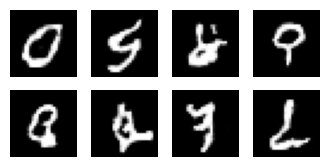

Time for epoch 131 is 41.48772096633911 sec
Epoch 130, Average Discriminator Loss: 0.6944762468338013, Average Generator Loss: 1.3867526054382324


2024-10-04 12:08:09.911169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 132 is 13.57424807548523 sec
Epoch 131, Average Discriminator Loss: 0.6929954886436462, Average Generator Loss: 1.3873893022537231


2024-10-04 12:08:21.161518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 133 is 11.248368740081787 sec
Epoch 132, Average Discriminator Loss: 0.7012011408805847, Average Generator Loss: 1.3810924291610718


2024-10-04 12:08:32.480264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 134 is 11.316435098648071 sec
Epoch 133, Average Discriminator Loss: 0.7004841566085815, Average Generator Loss: 1.3784621953964233


2024-10-04 12:13:23.566452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 135 is 291.0841917991638 sec
Epoch 134, Average Discriminator Loss: 0.6982297301292419, Average Generator Loss: 1.3829447031021118


2024-10-04 12:13:35.979829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 136 is 12.409057855606079 sec
Epoch 135, Average Discriminator Loss: 0.6959251165390015, Average Generator Loss: 1.3860663175582886


2024-10-04 12:13:48.431580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 137 is 12.448503971099854 sec
Epoch 136, Average Discriminator Loss: 0.6965696811676025, Average Generator Loss: 1.3875254392623901


2024-10-04 12:14:01.208682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 138 is 12.772924900054932 sec
Epoch 137, Average Discriminator Loss: 0.695600688457489, Average Generator Loss: 1.3879201412200928


2024-10-04 12:14:13.235820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 139 is 12.024693012237549 sec
Epoch 138, Average Discriminator Loss: 0.6935007572174072, Average Generator Loss: 1.3887770175933838


2024-10-04 12:14:25.409532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 140 is 12.17105507850647 sec
Epoch 139, Average Discriminator Loss: 0.6930417418479919, Average Generator Loss: 1.3888757228851318


2024-10-04 12:14:38.275809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


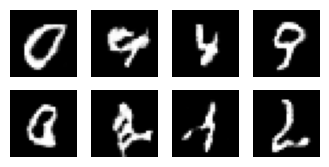

Time for epoch 141 is 13.03056287765503 sec
Epoch 140, Average Discriminator Loss: 0.6924835443496704, Average Generator Loss: 1.3886313438415527


2024-10-04 12:14:50.772659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 142 is 12.327836036682129 sec
Epoch 141, Average Discriminator Loss: 0.6935327649116516, Average Generator Loss: 1.3868807554244995


2024-10-04 12:15:03.026622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 143 is 12.251345157623291 sec
Epoch 142, Average Discriminator Loss: 0.693535566329956, Average Generator Loss: 1.3869194984436035


2024-10-04 12:15:15.574046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 144 is 12.544740915298462 sec
Epoch 143, Average Discriminator Loss: 0.6936773657798767, Average Generator Loss: 1.3876031637191772


2024-10-04 12:15:28.565145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 145 is 12.988573789596558 sec
Epoch 144, Average Discriminator Loss: 0.6971341371536255, Average Generator Loss: 1.3820970058441162


2024-10-04 12:15:41.573514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 146 is 13.004360914230347 sec
Epoch 145, Average Discriminator Loss: 0.7042110562324524, Average Generator Loss: 1.3852720260620117


2024-10-04 12:15:54.092414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 147 is 12.516002178192139 sec
Epoch 146, Average Discriminator Loss: 0.697842001914978, Average Generator Loss: 1.3834633827209473


2024-10-04 12:16:06.633025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 148 is 12.537823915481567 sec
Epoch 147, Average Discriminator Loss: 0.6982942819595337, Average Generator Loss: 1.384826898574829


2024-10-04 12:16:19.444557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 149 is 12.807862997055054 sec
Epoch 148, Average Discriminator Loss: 0.6927892565727234, Average Generator Loss: 1.3885468244552612


2024-10-04 12:16:32.878313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 150 is 13.431812763214111 sec
Epoch 149, Average Discriminator Loss: 0.6938316226005554, Average Generator Loss: 1.3882653713226318


2024-10-04 12:16:45.536662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


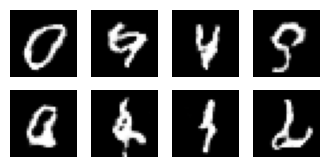

Time for epoch 151 is 12.729514837265015 sec
Epoch 150, Average Discriminator Loss: 0.6927188038825989, Average Generator Loss: 1.3892766237258911


2024-10-04 12:16:58.421696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 152 is 12.811047077178955 sec
Epoch 151, Average Discriminator Loss: 0.6926329135894775, Average Generator Loss: 1.3887540102005005


2024-10-04 12:17:11.202748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 153 is 12.779450178146362 sec
Epoch 152, Average Discriminator Loss: 0.6929650902748108, Average Generator Loss: 1.38820481300354


2024-10-04 12:17:24.085609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 154 is 12.880988121032715 sec
Epoch 153, Average Discriminator Loss: 0.6927437782287598, Average Generator Loss: 1.3878041505813599


2024-10-04 12:17:36.989649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 155 is 12.90217399597168 sec
Epoch 154, Average Discriminator Loss: 0.6930639743804932, Average Generator Loss: 1.3875534534454346


2024-10-04 12:17:49.849983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 156 is 12.858604907989502 sec
Epoch 155, Average Discriminator Loss: 0.6931217312812805, Average Generator Loss: 1.3869032859802246


2024-10-04 12:18:03.123194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 157 is 13.271924018859863 sec
Epoch 156, Average Discriminator Loss: 0.6945134401321411, Average Generator Loss: 1.3856555223464966


2024-10-04 12:18:16.623002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 158 is 13.498236894607544 sec
Epoch 157, Average Discriminator Loss: 0.699313223361969, Average Generator Loss: 1.3834806680679321


2024-10-04 12:18:30.496572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 159 is 13.871925115585327 sec
Epoch 158, Average Discriminator Loss: 0.705694854259491, Average Generator Loss: 1.3798630237579346
Time for epoch 160 is 14.49331283569336 sec
Epoch 159, Average Discriminator Loss: 0.6921075582504272, Average Generator Loss: 1.3864541053771973


2024-10-04 12:18:44.992219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


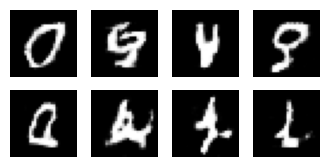

In [17]:
train(train_dataset, EPOCHS)

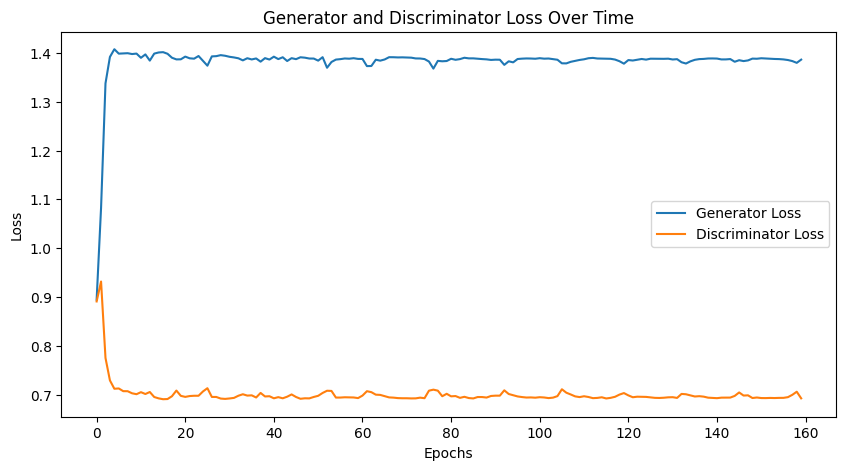

In [18]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(avg_gen_losses, label='Generator Loss')
plt.plot(avg_disc_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss Over Time')
plt.show()